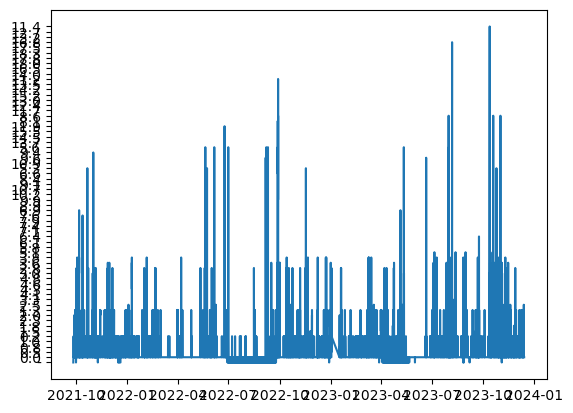

In [4]:
# -*- coding: utf-8 -*-
"""
Created on Wed Dec 13 12:48:01 2023

@author: Dimitri Schreuder
"""

import os
import pandas as pd
import matplotlib.pyplot as plt

os.chdir('C:\\Users\\Gebruiker\\Documents\\Programmeren\\Casus_waterbergende_weg\\')
filen = 'pr_tg_Hoogmade_id7dffd7e2-25e0-e711-9405-0003ff59b2bd.csv'

data = pd.read_csv(filen, delimiter= ';')
var = list(data) # columnames

pr = data[var[2]] # 
tt = pd.to_datetime(data["datum"])


plt.plot(tt, pr)

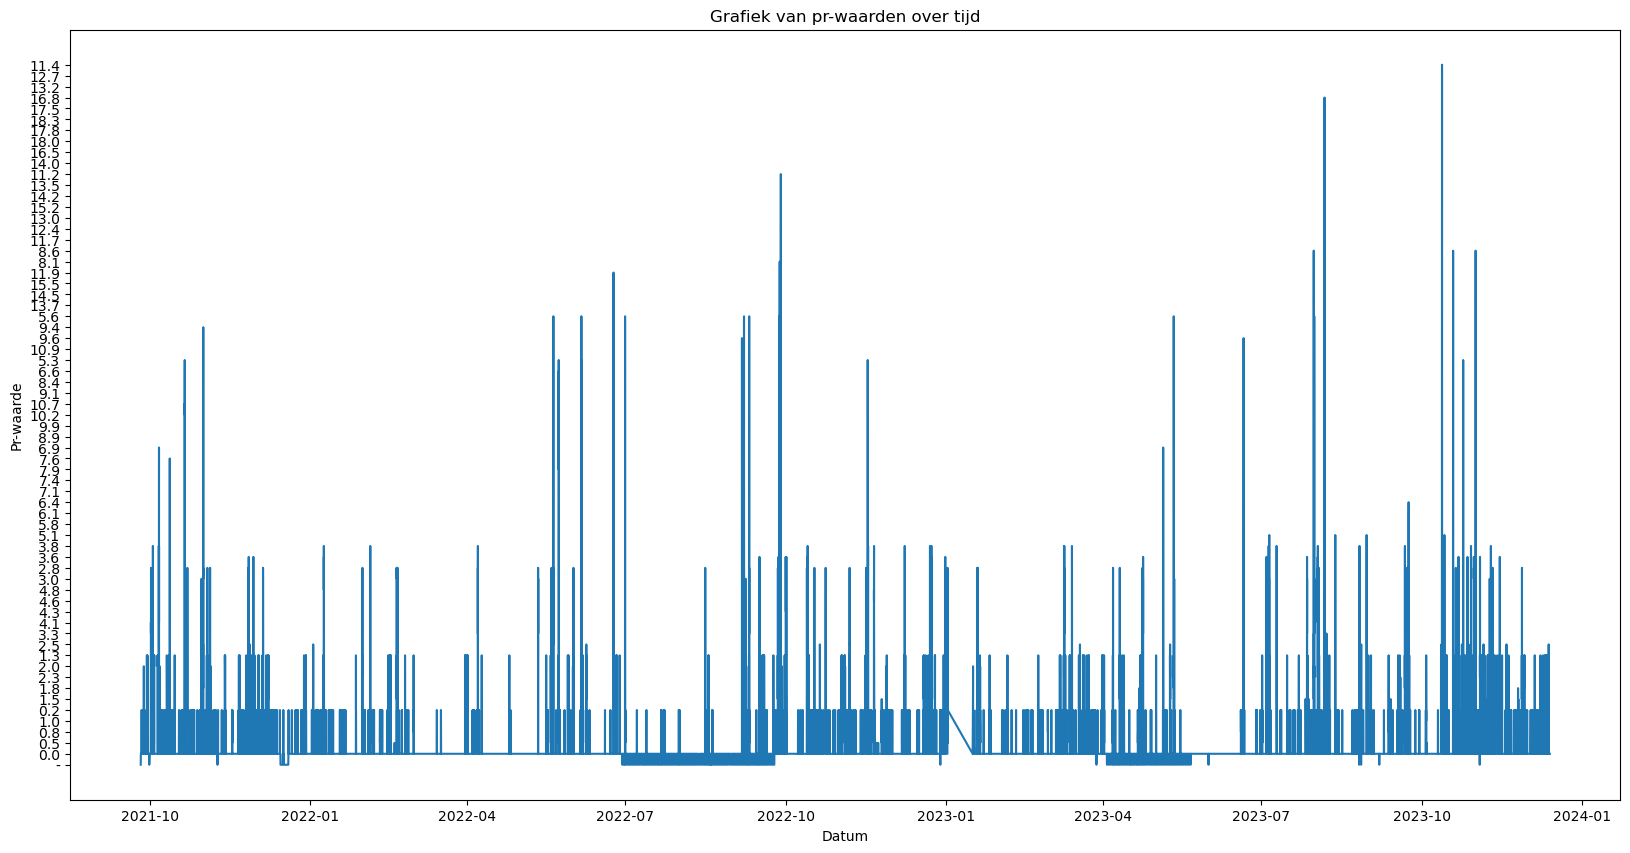

In [8]:
# -*- coding: utf-8 -*-
"""
Created on Wed Dec 13 12:48:01 2023

@author: Dimitri Schreuder
"""

import os
import pandas as pd
import matplotlib.pyplot as plt

# Wijzig de werkdirectory
os.chdir('C:\\Users\\Gebruiker\\Documents\\Programmeren\\Casus_waterbergende_weg\\')

# Bestandsnaam
filen = 'pr_tg_Hoogmade_id7dffd7e2-25e0-e711-9405-0003ff59b2bd.csv'

# Lees de gegevens in
data = pd.read_csv(filen, delimiter= ';')

# Haal de kolomnamen op
var = list(data.columns)

# Haal de gegevens op voor de plot
pr = data[var[2]]
tt = pd.to_datetime(data["datum"])

# Maak een nieuw figuur met aangepaste grootte
plt.figure(figsize=(20, 10))

# Plot de gegevens
plt.plot(tt, pr)

# Voeg labels toe aan de assen en een titel
plt.xlabel('Datum')
plt.ylabel('Pr-waarde')
plt.title('Grafiek van pr-waarden over tijd')

# Toon de plot
plt.show()



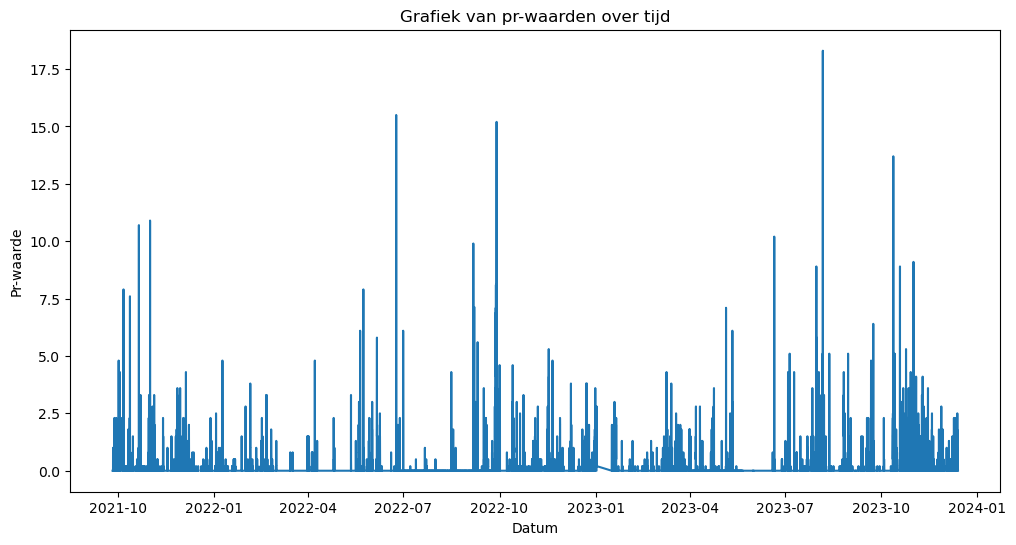

In [9]:
# -*- coding: utf-8 -*-
"""
Created on Wed Dec 13 12:48:01 2023

@author: Dimitri Schreuder
"""

import os
import pandas as pd
import matplotlib.pyplot as plt

# Wijzig de werkdirectory
os.chdir('C:\\Users\\Gebruiker\\Documents\\Programmeren\\Casus_waterbergende_weg\\')

# Bestandsnaam
filen = 'pr_tg_Hoogmade_id7dffd7e2-25e0-e711-9405-0003ff59b2bd.csv'

# Lees de gegevens in
data = pd.read_csv(filen, delimiter= ';')

# Haal de kolomnamen op
var = list(data.columns)

# Controleer en converteer de 'pr'-kolom naar numerieke waarden
data[var[2]] = pd.to_numeric(data[var[2]], errors='coerce')

# Haal de gegevens op voor de plot
pr = data[var[2]]
tt = pd.to_datetime(data["datum"])

# Maak een nieuw figuur met aangepaste grootte
plt.figure(figsize=(12, 6))

# Plot de gegevens
plt.plot(tt, pr)

# Voeg labels toe aan de assen en een titel
plt.xlabel('Datum')
plt.ylabel('Pr-waarde')
plt.title('Grafiek van pr-waarden over tijd')

# Toon de plot
plt.show()




In [10]:
print(pr)

0         NaN
1         0.0
2         NaN
3         0.0
4         0.0
         ... 
198479    0.0
198480    0.0
198481    0.0
198482    0.0
198483    0.0
Name: neerslagintensiteit (mm/uur) [7dffd7e2-25e0-e711-9405-0003ff59b2bd], Length: 198484, dtype: float64


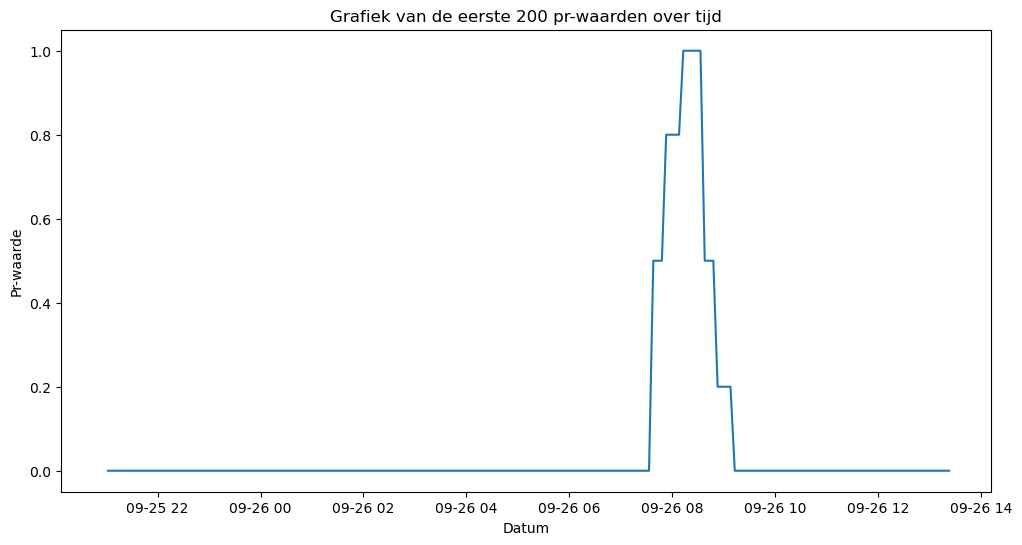

In [16]:
# -*- coding: utf-8 -*-
"""
Created on Wed Dec 13 12:48:01 2023

@author: Dimitri Schreuder
"""

import os
import pandas as pd
import matplotlib.pyplot as plt

# Wijzig de werkdirectory
os.chdir('C:\\Users\\Gebruiker\\Documents\\Programmeren\\Casus_waterbergende_weg\\')

# Bestandsnaam
filen = 'pr_tg_Hoogmade_id7dffd7e2-25e0-e711-9405-0003ff59b2bd.csv'

# Lees de gegevens in
data = pd.read_csv(filen, delimiter= ';')

# Haal de kolomnamen op
var = list(data.columns)

# Controleer en converteer de 'pr'-kolom naar numerieke waarden
data[var[2]] = pd.to_numeric(data[var[2]], errors='coerce')

# Haal de gegevens op voor de plot (alleen de eerste 20 rijen)
pr = data[var[2]][:200]
tt = pd.to_datetime(data["datum"][:200])

# Maak een nieuw figuur met aangepaste grootte
plt.figure(figsize=(12, 6))

# Plot de gegevens
plt.plot(tt, pr)

# Voeg labels toe aan de assen en een titel
plt.xlabel('Datum')
plt.ylabel('Pr-waarde')
plt.title('Grafiek van de eerste 200 pr-waarden over tijd')

# Toon de plot
plt.show()


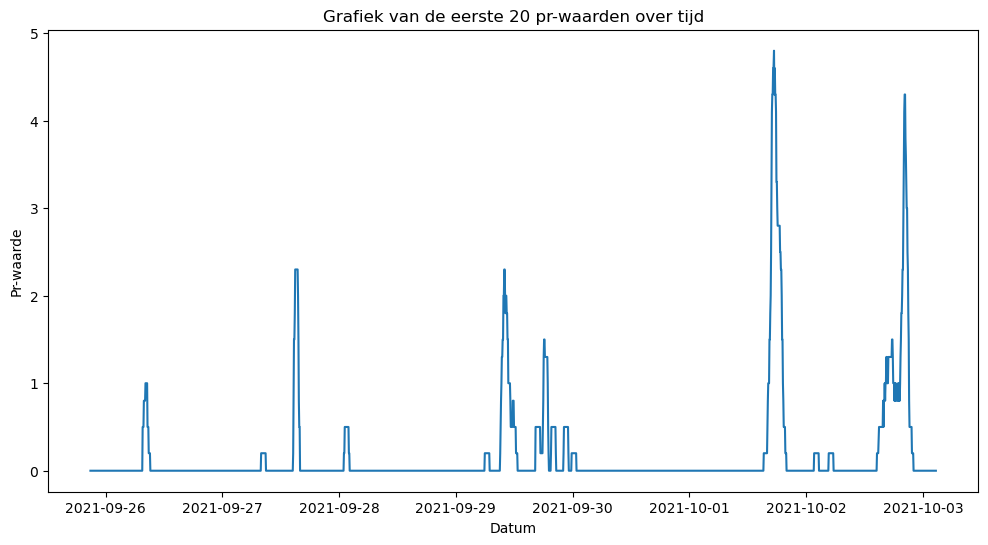

In [18]:
# -*- coding: utf-8 -*-
"""
Created on Wed Dec 13 12:48:01 2023

@author: Dimitri Schreuder
"""

import os
import pandas as pd
import matplotlib.pyplot as plt

# Wijzig de werkdirectory
os.chdir('C:\\Users\\Gebruiker\\Documents\\Programmeren\\Casus_waterbergende_weg\\')

# Bestandsnaam
filen = 'pr_tg_Hoogmade_id7dffd7e2-25e0-e711-9405-0003ff59b2bd.csv'

# Lees de gegevens in
data = pd.read_csv(filen, delimiter= ';')

# Haal de kolomnamen op
var = list(data.columns)

# Controleer en converteer de 'pr'-kolom naar numerieke waarden
data[var[2]] = pd.to_numeric(data[var[2]], errors='coerce')

# Vervang NaN-waarden door 0.0 in de 'pr'-kolom
data[var[2]].fillna(0.0, inplace=True)

# Haal de gegevens op voor de plot (alleen de eerste 20 rijen)
pr = data[var[2]][:2000]
tt = pd.to_datetime(data["datum"][:2000])

# Maak een nieuw figuur met aangepaste grootte
plt.figure(figsize=(12, 6))

# Plot de gegevens
plt.plot(tt, pr)

# Voeg labels toe aan de assen en een titel
plt.xlabel('Datum')
plt.ylabel('Pr-waarde')
plt.title('Grafiek van de eerste 20 pr-waarden over tijd')

# Toon de plot
plt.show()


In [19]:
print(pr)


0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
1995    0.0
1996    0.0
1997    0.0
1998    0.0
1999    0.0
Name: neerslagintensiteit (mm/uur) [7dffd7e2-25e0-e711-9405-0003ff59b2bd], Length: 2000, dtype: float64


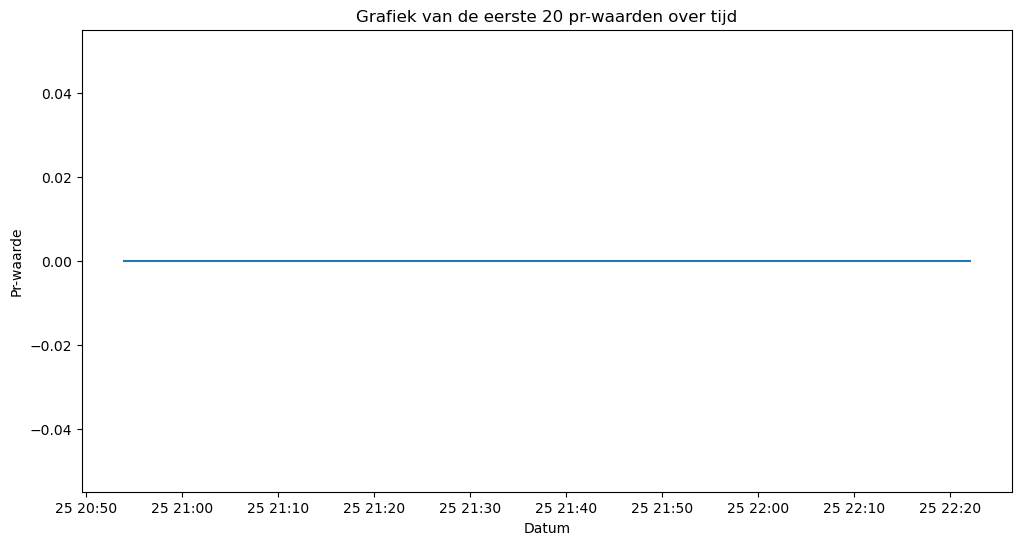

Aangepaste gegevens als lijst:
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [20]:
# -*- coding: utf-8 -*-
"""
Created on Wed Dec 13 12:48:01 2023

@author: Dimitri Schreuder
"""

import os
import pandas as pd
import matplotlib.pyplot as plt

# Wijzig de werkdirectory
os.chdir('C:\\Users\\Gebruiker\\Documents\\Programmeren\\Casus_waterbergende_weg\\')

# Bestandsnaam
origineel_bestand = 'pr_tg_Hoogmade_id7dffd7e2-25e0-e711-9405-0003ff59b2bd.csv'

# Lees de originele gegevens in
data = pd.read_csv(origineel_bestand, delimiter= ';')

# Haal de kolomnamen op
var = list(data.columns)

# Controleer en converteer de 'pr'-kolom naar numerieke waarden
data[var[2]] = pd.to_numeric(data[var[2]], errors='coerce')

# Vervang NaN-waarden door 0.0 in de 'pr'-kolom
data[var[2]].fillna(0.0, inplace=True)

# Converteer de DataFrame naar een lijst
aangepaste_data_list = data[var[2]][:20].tolist()

# Haal de gegevens op voor de plot (alleen de eerste 20 rijen)
pr = data[var[2]][:20]
tt = pd.to_datetime(data["datum"][:20])

# Maak een nieuw figuur met aangepaste grootte
plt.figure(figsize=(12, 6))

# Plot de gegevens
plt.plot(tt, pr)

# Voeg labels toe aan de assen en een titel
plt.xlabel('Datum')
plt.ylabel('Pr-waarde')
plt.title('Grafiek van de eerste 20 pr-waarden over tijd')

# Toon de plot
plt.show()

# Geef de lijst van aangepaste gegevens weer
print("Aangepaste gegevens als lijst:")
print(aangepaste_data_list)


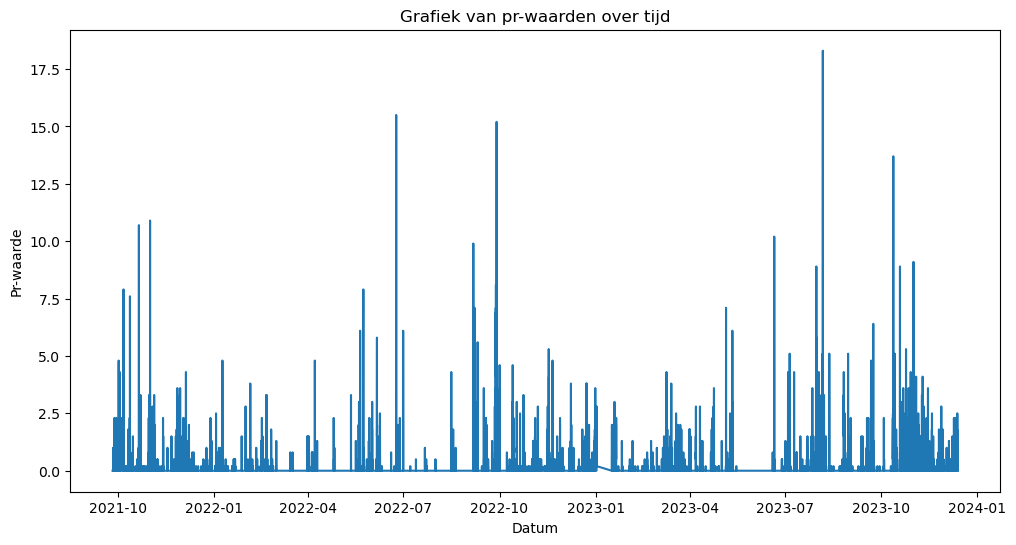

In [24]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# Wijzig de werkdirectory
os.chdir('C:\\Users\\Gebruiker\\Documents\\Programmeren\\Casus_waterbergende_weg\\')

# Bestandsnaam
origineel_bestand = 'pr_tg_Hoogmade_id7dffd7e2-25e0-e711-9405-0003ff59b2bd.csv'

# Lees de originele gegevens in
data = pd.read_csv(origineel_bestand, delimiter= ';')

# Haal de kolomnamen op
var = list(data.columns)

# Controleer en converteer de 'pr'-kolom naar numerieke waarden
data[var[2]] = pd.to_numeric(data[var[2]], errors='coerce')

# Vervang NaN-waarden door 0.0 in de 'pr'-kolom
data[var[2]].fillna(0.0, inplace=True)

# Converteer de 'pr'-kolom naar een lijst
aangepaste_data_list = data[var[2]].tolist()

# Haal de gegevens op voor de plot
pr = data[var[2]]
tt = pd.to_datetime(data["datum"])

# Maak een nieuw figuur met aangepaste grootte
plt.figure(figsize=(12, 6))

# Plot de gegevens
plt.plot(tt, pr)

# Voeg labels toe aan de assen en een titel
plt.xlabel('Datum')
plt.ylabel('Pr-waarde')
plt.title('Grafiek van pr-waarden over tijd')

# Toon de plot
plt.show()

# Geef de lijst van aangepaste gegevens weer
#print("Aangepaste gegevens als lijst:")
#print(aangepaste_data_list)
